##  **Copy Number Variation (CNV)**
A copy number variation (CNV) is when the number of copies of a particular gene varies from one individual to the next. Following the completion of the Human Genome Project, it became apparent that the genome experiences gains and losses of genetic material. The extent to which copy number variation contributes to human disease is not yet known. It has long been recognized that some cancers are associated with elevated copy numbers of particular genes.

Copy number variation is a type of structural variation where you have a stretch of DNA, which is duplicated in some people, and sometimes even triplicated or quadruplicated. And so when you look at that chromosomal region, you will see a variation in the number of copies in normal people. Sometimes those copy number variants include genes, maybe several genes, which may mean that this person has four copies of that gene instead of the usual two, and somebody else has three, and somebody else has five. Interesting, we didn't really expect to see so much of that. It's now turning out to be pretty common, and in some instances, if those genes are involved in functions that are sensitive to the dosage, you might then see a consequence in terms of a disease risk.

Francis S. Collins, M.D., Ph.D. 

In [ ]:
import sys
from os import listdir
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # Imported for legends
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path_BRCA = '/content/drive/My Drive/Copy number sensitive genomic regions/TCGA-BRCA' 
path_DLBC = '/content/drive/My Drive/Copy number sensitive genomic regions/TCGA-DLBC'

In [ ]:
# get all datasets as objects
def get_data_as_objects_from_files(path,N):
    dirs= listdir(path)
    objects=[]
    for i in range(0,N):
        dir = dirs[i]
        if not dir.endswith('.txt'): continue
        input=path+'/'+dir
        name = dir.split('.txt')[0]
        with open(input, 'r') as in_file:
            dataObject=[]
            lines = in_file.readlines()
            header = lines[0].split('\t')
            lines = lines[1:]
            for line in lines:
                line_array = line.split('\t')
                obj = {'id':line_array[0] , 'Chromosome':line_array[1] ,'Start':line_array[2], 'End':line_array[3] , 'Copy_Number':line_array[4]}
                dataObject.append(obj)

            objects.append(dataObject)
    return objects

In [ ]:
# get all intersection of two arrays
def intersections(a,b):
    ranges = []
    i = j = 0
    while i < len(a) and j < len(b):
        a_left, a_right = a[i]
        b_left, b_right = b[j]
        if a_right < b_right:
            i += 1
        else:
            j += 1
        if a_right >= b_left and b_right >= a_left:
            end_pts = sorted([a_left, a_right, b_left, b_right])
            middle = [end_pts[1], end_pts[2]]
            ranges.append(middle)
    ri = 0
    while ri < len(ranges)-1:
        if ranges[ri][1] == ranges[ri+1][0]:
            ranges[ri:ri+2] = [[ranges[ri][0], ranges[ri+1][1]]]

        ri += 1
    return ranges


In [ ]:
# filter sections of chromosome i by copy number
def filter_range_of_chromosome_i_by_copyNumber(i,cn,person):
    ranges= [[int(row['Start']),int(row['End'])] for row in person if (row['Chromosome'] == 'chr'+str(i)) and int(row['Copy_Number']) == cn]
    return ranges

In [ ]:
# get all sections of all persons by copy number cn
def get_all_ranges_by_copyNumber(data,cn):
    persons_chromosome_sections = []
    for person in data:
        person_chromosome_sections = []
        for i in range(1,23): # 22 chromosomes chr i
            sections =filter_range_of_chromosome_i_by_copyNumber(i,cn,person)
            person_chromosome_sections.append({'chr':i , 'sections':sections})
        sections = filter_range_of_chromosome_i_by_copyNumber('X', cn, person)
        person_chromosome_sections.append({'chr': 'X', 'sections': sections})
        sections = filter_range_of_chromosome_i_by_copyNumber('Y', cn, person)
        person_chromosome_sections.append({'chr': 'Y', 'sections': sections})

        persons_chromosome_sections.append(person_chromosome_sections)
    return persons_chromosome_sections

In [ ]:
def intersections_all_chomosomes_sections(persons_chromosome_sections):
    intersections_by_chr=[]
    for i in range(0,24):
        chr = str(i+1) if i<=21 else ('X' if i == 22 else 'Y')
        acc = [[1, sys.maxsize]]
        for person in persons_chromosome_sections:
            acc = intersections(acc, person[i]['sections'])
        intersections_by_chr.append({'chr':chr , 'sections':acc})
    return intersections_by_chr

In [ ]:
def split_into_groups(n,data):
    sets = [data[i * n:(i + 1) * n] for i in range(len(data) // n)]
    return sets
      

In [ ]:
def data_to_intervals(data):
    inter = []
    for row in data:
        sections = []
        for sec in row['sections']:
            sections.append((sec[0],sec[1]))
        inter.append({'chr':row['chr'] , 'sections':sections})
    return inter

In [ ]:
# Adding the legends
def make_proxy(col, scalar_mappable, **kwargs):
  return Line2D([0, 1], [0, 1], color=col, **kwargs)

def make_line_plot(sections, title):
  intervals = sections
  intervals = [np.array(sec).tolist() for sec in intervals]
  num_intervals = len(intervals)
  viridis = plt.cm.get_cmap('viridis', num_intervals)
  colors = np.array([viridis(idx / num_intervals) for idx in range(len(intervals)*4)])

  fig, ax = plt.subplots()
  lines = []
  color = 1
  lc = []
  chr_num=[]
  proxies = []
  for x in intervals:
    if (len(x) > 0):
      chr_num.append(intervals.index(x))
      for intv in x:
        lc1 = LineCollection([[(intv[0], intervals.index(x)), (intv[1], intervals.index(x))]], colors= colors[color], linewidths=4)
        ax.add_collection(lc1)
        lc.append(lc1)
      proxies.append(make_proxy(colors[color], lc, linewidth=2))
      lc=[]
      color+=1;

  ax.margins(0.1)
  plt.yticks(np.arange(0, 25, step=1))
  plt.title(title)

  ax.legend(proxies, ['chr'+str(x+1) for x in chr_num])

In [ ]:
def get_data(path, num):
  data = get_data_as_objects_from_files(path,num)
  persons_chromosome_sections = get_all_ranges_by_copyNumber(data,2)
  intersection = intersections_all_chomosomes_sections(persons_chromosome_sections)
  # call to plot
  data = data_to_intervals(intersection)
  data_df = pd.DataFrame(data)
  return data_df;

In [ ]:
def get_num_of_overlaps(df):
  intervals = df['sections']
  intervals = [np.array(sec).tolist() for sec in intervals]
  
  count = 0
  for inv in intervals:
    if (len(inv) > 0):
      for e in inv:
        count += e[1] - e[0]
  return count

In [ ]:
def get_cnvs(data):
    cnvs=[]
    for subject in data:
        for row in subject:
            val = int(row['Copy_Number'])
            cnvs.append(val)
    return cnvs

In [ ]:
def data_analysis(data):
    total = 0
    cns = [0, 0, 0, 0, 0, 0]
    for subject in data:
        for row in subject:
            val = int(row['Copy_Number'])
            if val < 5:
                cns[val] += float(row['End']) - float(row['Start'])
            else:
                cns[5] += float(row['End']) - float(row['Start'])
    total = cns[0] +cns[1] + cns[2]+ cns[3] + cns[4] + cns[5]
    return cns , total

In [ ]:
def intersections_all_chomosomes_sections2(persons_chromosome_sections):
    inter=[]
    acc = [[1, sys.maxsize]]
    for person in persons_chromosome_sections:
        acc = intersections(acc, person)
    return acc

In [ ]:
def get_by_id(id,data):
    for o in data:
        if o[0]['id'] == id:
            return o

In [ ]:
def get_prob(data):
    total = 0
    cns = 0
    prob=1
    for subject in data:
        for row in subject:
            val = int(row['Copy_Number'])
            if val == 2:
                cns += float(row['End']) - float(row['Start'])
            total +=float(row['End']) - float(row['Start'])
        prob = (prob* (cns/total)) 
    return (prob * pow(10,9))

**Extract data as objects from dataset**

In [ ]:
BRCA_all_data = get_data_as_objects_from_files(path_BRCA, 100)
DLBC_all_data = get_data_as_objects_from_files(path_DLBC, 40)

### **Summary of the copy number variation (CNV) analysis**

**Breast Cancer type: TCGA-BRCA**

In [ ]:
percent = lambda part, whole: (float(part) / float(whole)) * 100
cns , total = data_analysis(BRCA_all_data)
percent = lambda part, whole: (float(part) / float(whole)) * 100
copy_numbers = {'CNV Type': ['Total CNVs Length','Deletion (CN = 0)','Deletion (CN = 1)','Deploid (CN = 2)','Duplication (CN = 3)','Duplication (CN = 4)','Duplication (CN > 4)'],
        '   Sum of Segments Length': [total,cns[0],cns[1],cns[2],cns[3],cns[4],cns[5]],
                'Percentage' : [100,percent(cns[0],total), percent(cns[1],total),percent(cns[2],total),percent(cns[3],total),percent(cns[4],total),percent(cns[5],total)]
        }

df = pd.DataFrame(copy_numbers, columns = ['CNV Type','Percentage'])
df

,CNV Type,Percentage
0,Total CNVs Length,100.000000
1,Deletion (CN = 0),1.091196
2,Deletion (CN = 1),8.317083
3,Deploid (CN = 2),49.943065
4,Duplication (CN = 3),16.170187
5,Duplication (CN = 4),16.473890
6,Duplication (CN > 4),8.004579


**Breast Cancer type: TCGA-DLBC**

In [ ]:
cns , total = data_analysis(DLBC_all_data)
percent = lambda part, whole: (float(part) / float(whole)) * 100
copy_numbers = {'CNV Type': ['Total CNVs Length','Deletion (CN = 0)','Deletion (CN = 1)','Deploid (CN = 2)','Duplication (CN = 3)','Duplication (CN = 4)','Duplication (CN > 4)'],
        '   Sum of Segments Length': [total,cns[0],cns[1],cns[2],cns[3],cns[4],cns[5]],
                'Percentage' : [100,percent(cns[0],total), percent(cns[1],total),percent(cns[2],total),percent(cns[3],total),percent(cns[4],total),percent(cns[5],total)]
        }

df = pd.DataFrame(copy_numbers, columns = ['CNV Type' ,'Percentage'])
df

,CNV Type,Percentage
0,Total CNVs Length,100.000000
1,Deletion (CN = 0),2.088359
2,Deletion (CN = 1),5.326148
3,Deploid (CN = 2),61.764916
4,Duplication (CN = 3),10.149470
5,Duplication (CN = 4),14.727591
6,Duplication (CN > 4),5.943515


### **Comparition between two subjects by copy number percentage**

**Breast Cancer type: TCGA-BRCA**

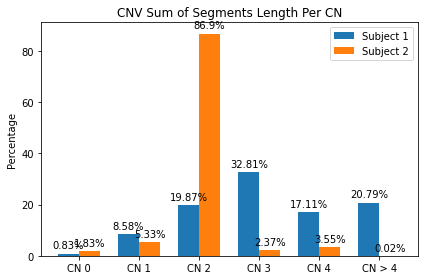

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#lowest = get_by_id('f875e50e-fc0f-4421-8ffb-4fec24d3340c',BRCA_all_data)
cns1 , total1 = data_analysis([BRCA_all_data[3]])
cns2 , total2 = data_analysis([BRCA_all_data[0]])
labels = ['CN 0', 'CN 1', 'CN 2', 'CN 3','CN 4' ,'CN > 4']
subject1 = [round(percent(cns1[0],total1),2), round(percent(cns1[1],total1),2),round(percent(cns1[2],total1),2),round(percent(cns1[3],total1),2),round(percent(cns1[4],total1),2),round(percent(cns1[5],total1),2)]
subject2 = [round(percent(cns2[0],total2),2), round(percent(cns2[1],total2),2),round(percent(cns2[2],total2),2),round(percent(cns2[3],total2),2),round(percent(cns2[4],total2),2),round(percent(cns2[5],total2),2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, subject1, width, label='Subject 1')
rects2 = ax.bar(x + width/2, subject2, width, label='Subject 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('CNV Sum of Segments Length Per CN')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Breast Cancer type: TCGA-DLBC**

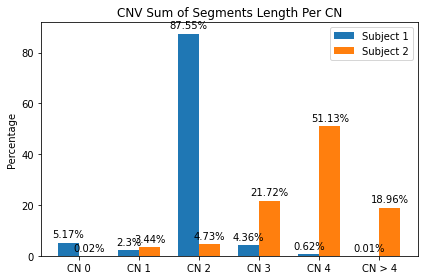

In [ ]:
#lowest = get_by_id('f875e50e-fc0f-4421-8ffb-4fec24d3340c',BRCA_all_data)
cns1 , total1 = data_analysis([DLBC_all_data[3]])
cns2 , total2 = data_analysis([DLBC_all_data[0]])
labels = ['CN 0', 'CN 1', 'CN 2', 'CN 3','CN 4' ,'CN > 4']
subject1 = [round(percent(cns1[0],total1),2), round(percent(cns1[1],total1),2),round(percent(cns1[2],total1),2),round(percent(cns1[3],total1),2),round(percent(cns1[4],total1),2),round(percent(cns1[5],total1),2)]
subject2 = [round(percent(cns2[0],total2),2), round(percent(cns2[1],total2),2),round(percent(cns2[2],total2),2),round(percent(cns2[3],total2),2),round(percent(cns2[4],total2),2),round(percent(cns2[5],total2),2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, subject1, width, label='Subject 1')
rects2 = ax.bar(x + width/2, subject2, width, label='Subject 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('CNV Sum of Segments Length Per CN')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### **Overlap between all subjects (1000) with unchanged copy number (cp = 2)**

**Breast Cancer type: TCGA-BRCA**

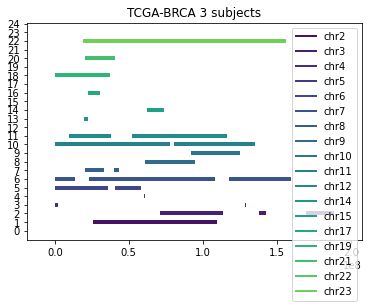

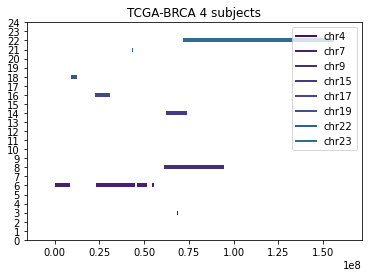

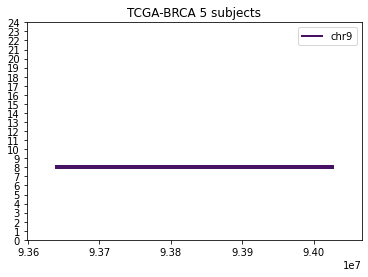

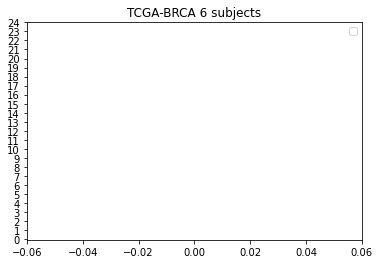

In [ ]:
BRCA_data2 = get_data(path_BRCA, 2)
BRCA_data3 = get_data(path_BRCA, 3)
BRCA_data4 = get_data(path_BRCA, 4)
BRCA_data5 = get_data(path_BRCA, 5)
BRCA_data6 = get_data(path_BRCA, 6)
make_line_plot(BRCA_data3['sections'], 'TCGA-BRCA 3 subjects')
make_line_plot(BRCA_data4['sections'], 'TCGA-BRCA 4 subjects')
make_line_plot(BRCA_data5['sections'], 'TCGA-BRCA 5 subjects')
make_line_plot(BRCA_data6['sections'], 'TCGA-BRCA 6 subjects')

**Breast Cancer type: TCGA-DLBC**

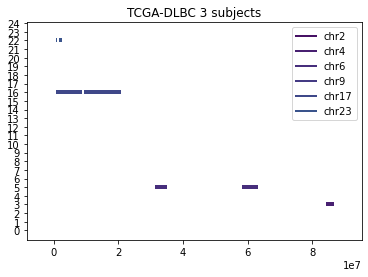

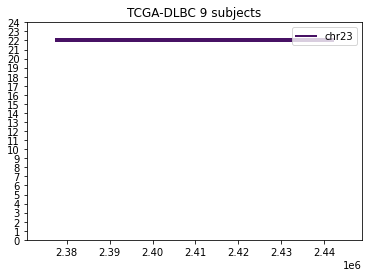

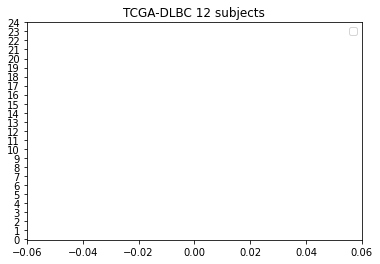

In [ ]:
DLBC_data2 = get_data(path_DLBC, 2)
DLBC_data3 = get_data(path_DLBC, 3)
DLBC_data4 = get_data(path_DLBC, 4)
DLBC_data5 = get_data(path_DLBC, 5)
DLBC_data6 = get_data(path_DLBC, 6)
DLBC_data7 = get_data(path_DLBC, 7)
DLBC_data8 = get_data(path_DLBC, 8)
DLBC_data9 = get_data(path_DLBC, 9)
DLBC_data10 = get_data(path_DLBC, 10)
DLBC_data11 = get_data(path_DLBC, 11)
DLBC_data12 = get_data(path_DLBC, 12)
# make_line_plot(DLBC_data3['sections'], 'TCGA-DLBC 3 subjects')
# make_line_plot(DLBC_data4['sections'], 'TCGA-DLBC 4 subjects')
make_line_plot(DLBC_data3['sections'], 'TCGA-DLBC 3 subjects')
make_line_plot(DLBC_data9['sections'], 'TCGA-DLBC 9 subjects')
make_line_plot(DLBC_data12['sections'], 'TCGA-DLBC 12 subjects')

**Showing decsent in number of overlaps depends the size of the group**

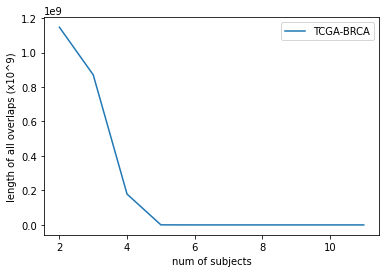

In [ ]:
all_overlaps1 = [get_num_of_overlaps(BRCA_data2), get_num_of_overlaps(BRCA_data3), get_num_of_overlaps(BRCA_data4),get_num_of_overlaps(BRCA_data5),
                get_num_of_overlaps(BRCA_data6)]
x1 = [0 for y in range(6, 11)]
subj1 = np.concatenate(([2,3,4,5,6], [y for y in range(7, 12)]))
conc1 = np.concatenate((all_overlaps1, x1))



plt.xlabel('num of subjects')
plt.ylabel('length of all overlaps (x10^9)')
plt.plot(subj1, conc1)


plt.legend(["TCGA-BRCA"])

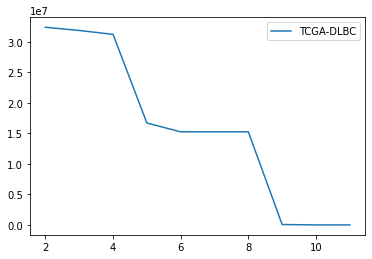

In [ ]:
all_overlaps2 = [get_num_of_overlaps(DLBC_data2), get_num_of_overlaps(DLBC_data3), get_num_of_overlaps(DLBC_data4),get_num_of_overlaps(DLBC_data5),
                get_num_of_overlaps(DLBC_data6), get_num_of_overlaps(DLBC_data7), get_num_of_overlaps(DLBC_data8), get_num_of_overlaps(DLBC_data9),
                get_num_of_overlaps(DLBC_data10), get_num_of_overlaps(DLBC_data11)]

x2 = [0 for y in range(11, 11)]
subj2 = np.concatenate(([2,3,4,5,6,7,8,9,10], [y for y in range(11, 12)]))
conc2 = np.concatenate((all_overlaps2, x2))

plt.plot(subj2, conc2)
plt.legend(["TCGA-DLBC"])

### Probability for overlap between N subjects with cn = 2 
**Breast Cancer type: TCGA-BRCA**

In [ ]:
get_prob(BRCA_all_data[:50])

1.0663581808761247e-06

**Breast Cancer type: TCGA-DLBC**

In [ ]:
get_prob(DLBC_all_data[:50])

0.05942628246569958